In [1]:
# Laden der Packages
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from math import sqrt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]

In [5]:
# Preprocessing der Rohdaten: 100%
ZR_100new=np.atleast_2d(ZR_100)
if ZR_100new.shape[0]==1:
    ZR_100new=ZR_100new.T
nb_samples_100, nb_series_100 = ZR_100new.shape

In [6]:
# Preprocessing der Rohdaten: 46%
ZR_46new=np.atleast_2d(ZR_46)
if ZR_46new.shape[0]==1:
    ZR_46new=ZR_46new.T
nb_samples_46, nb_series_46 = ZR_46new.shape

In [7]:
# Einteilung in Trainings- und Testdaten: nicht mehr ZR sondern X --> X_train etc
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

test_size_46=int(0.35*nb_samples_46)
train_46, test_46 = ZR_46[:-test_size_46], ZR_46[-test_size_46:]

In [8]:
# Shape des Input und Outputs anpassen: 100%
look_forward=60
window_size=12
# Trainingsdaten
Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=train_100[window_size+look_forward:]
qtrain_100=np.atleast_3d([train_100[-(window_size):]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

# Testdaten
Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=test_100[window_size+look_forward:]
qtest_100=np.atleast_3d([test_100[-(window_size):]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (533,) (533, 12, 1)
(1, 12, 1) (186,) (186, 12, 1)


In [9]:
# Shape des Input und Outputs anpassen: 46%
# Trainingsdaten
Xtrain_46=np.atleast_3d(np.array([train_46[start:start+window_size] for start in range(0, train_46.shape[0]-(window_size+look_forward))]))
ytrain_46=train_46[window_size+look_forward:]
qtrain_46=np.atleast_3d([train_46[-(window_size):]])
print(qtrain_46.shape, ytrain_46.shape, Xtrain_46.shape)

# Testdaten
Xtest_46=np.atleast_3d(np.array([test_46[start:start+window_size] for start in range(0, test_46.shape[0]-(window_size+look_forward))]))
ytest_46=test_46[window_size+look_forward:]
qtest_46=np.atleast_3d([test_46[-(window_size):]])
print(qtest_46.shape, ytest_46.shape, Xtest_46.shape)

(1, 12, 1) (188,) (188, 12, 1)
(1, 12, 1) (68,) (68, 12, 1)


In [10]:
# Modell zusammenbauen: 
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='relu', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Convolution1D(nb_filter=nb_filter_3, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(nb_outputs, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  del sys.path[0]


In [11]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [12]:
# Replizierbarkeit gewährleisten
np.random.seed(2)

In [13]:
# Modellanpassen: 100%
history_reg=model.fit(Xtrain_100, ytrain_100, epochs=200, batch_size=25, validation_data=(Xtest_100, ytest_100))

Train on 533 samples, validate on 186 samples
Epoch 1/200
533/533 [==============================] - 1s 2ms/step - loss: 4097980084.9531 - mean_absolute_error: 58356.2592 - val_loss: 113208562.1505 - val_mean_absolute_error: 8531.4545
Epoch 2/200
533/533 [==============================] - 0s 469us/step - loss: 542805523.9024 - mean_absolute_error: 18441.7193 - val_loss: 101596556.4624 - val_mean_absolute_error: 7934.9043
Epoch 3/200
533/533 [==============================] - 0s 498us/step - loss: 398686323.4822 - mean_absolute_error: 15938.1564 - val_loss: 49298521.5484 - val_mean_absolute_error: 5738.7535
Epoch 4/200
533/533 [==============================] - 0s 469us/step - loss: 368560682.1163 - mean_absolute_error: 14605.4037 - val_loss: 51252822.5484 - val_mean_absolute_error: 5555.9890
Epoch 5/200
533/533 [==============================] - 0s 469us/step - loss: 358024299.6173 - mean_absolute_error: 14955.3758 - val_loss: 48325120.3763 - val_mean_absolute_error: 5503.7580
Epoch 6/

Epoch 44/200
533/533 [==============================] - 0s 557us/step - loss: 302625988.2326 - mean_absolute_error: 13650.9767 - val_loss: 84099235.8226 - val_mean_absolute_error: 7071.4950
Epoch 45/200
533/533 [==============================] - 0s 528us/step - loss: 323681655.6548 - mean_absolute_error: 14158.5260 - val_loss: 48135931.6559 - val_mean_absolute_error: 5390.3669
Epoch 46/200
533/533 [==============================] - 0s 498us/step - loss: 341507465.1557 - mean_absolute_error: 14495.1709 - val_loss: 56261734.3871 - val_mean_absolute_error: 6309.1202
Epoch 47/200
533/533 [==============================] - 0s 498us/step - loss: 315318555.8574 - mean_absolute_error: 13779.4002 - val_loss: 46802740.3817 - val_mean_absolute_error: 5594.5170
Epoch 48/200
533/533 [==============================] - 0s 498us/step - loss: 294873753.8762 - mean_absolute_error: 13494.5564 - val_loss: 46010687.8871 - val_mean_absolute_error: 5376.7338
Epoch 49/200
533/533 [============================

Epoch 87/200
533/533 [==============================] - 0s 469us/step - loss: 256770294.8143 - mean_absolute_error: 12531.5821 - val_loss: 47418403.1774 - val_mean_absolute_error: 5333.7667
Epoch 88/200
533/533 [==============================] - 0s 586us/step - loss: 244042092.9981 - mean_absolute_error: 12292.8981 - val_loss: 46964811.4194 - val_mean_absolute_error: 5320.7605
Epoch 89/200
533/533 [==============================] - 0s 586us/step - loss: 267194771.4972 - mean_absolute_error: 12607.5102 - val_loss: 63207106.7419 - val_mean_absolute_error: 5980.7290
Epoch 90/200
533/533 [==============================] - 0s 528us/step - loss: 265272218.9268 - mean_absolute_error: 12820.4773 - val_loss: 46588970.9892 - val_mean_absolute_error: 5564.5045
Epoch 91/200
533/533 [==============================] - 0s 498us/step - loss: 268521236.9831 - mean_absolute_error: 12700.0076 - val_loss: 45540681.0484 - val_mean_absolute_error: 5387.3973
Epoch 92/200
533/533 [============================

Epoch 130/200
533/533 [==============================] - 0s 498us/step - loss: 236578858.7017 - mean_absolute_error: 12193.4764 - val_loss: 48962122.0645 - val_mean_absolute_error: 5779.5167
Epoch 131/200
533/533 [==============================] - 0s 557us/step - loss: 231065215.4897 - mean_absolute_error: 12021.3178 - val_loss: 45218052.7043 - val_mean_absolute_error: 5379.0356
Epoch 132/200
533/533 [==============================] - 0s 498us/step - loss: 244335615.2495 - mean_absolute_error: 12221.8207 - val_loss: 48752208.8495 - val_mean_absolute_error: 5301.4591
Epoch 133/200
533/533 [==============================] - 0s 498us/step - loss: 231679836.2176 - mean_absolute_error: 12200.3697 - val_loss: 46498759.0430 - val_mean_absolute_error: 5259.3900
Epoch 134/200
533/533 [==============================] - 0s 469us/step - loss: 232402442.0863 - mean_absolute_error: 12140.6588 - val_loss: 45635207.3333 - val_mean_absolute_error: 5428.4905
Epoch 135/200
533/533 [======================

Epoch 173/200
533/533 [==============================] - 0s 498us/step - loss: 214067598.7392 - mean_absolute_error: 11587.9046 - val_loss: 47773748.2151 - val_mean_absolute_error: 5459.0506
Epoch 174/200
533/533 [==============================] - 0s 557us/step - loss: 224364805.6435 - mean_absolute_error: 11800.3087 - val_loss: 49880103.8118 - val_mean_absolute_error: 5763.4550
Epoch 175/200
533/533 [==============================] - 0s 528us/step - loss: 229592347.3171 - mean_absolute_error: 11854.5702 - val_loss: 54671944.7581 - val_mean_absolute_error: 6117.3616
Epoch 176/200
533/533 [==============================] - 0s 469us/step - loss: 251386035.3321 - mean_absolute_error: 12575.7103 - val_loss: 48774372.7151 - val_mean_absolute_error: 5644.7916
Epoch 177/200
533/533 [==============================] - 0s 528us/step - loss: 231493294.0338 - mean_absolute_error: 11807.7233 - val_loss: 53158060.8710 - val_mean_absolute_error: 5586.3244
Epoch 178/200
533/533 [======================

Text(0.5,1,'Loss Curves')

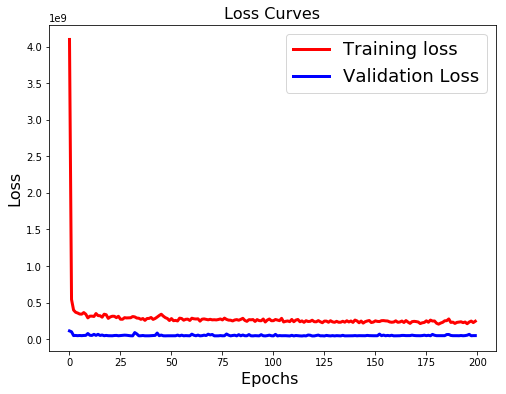

In [14]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

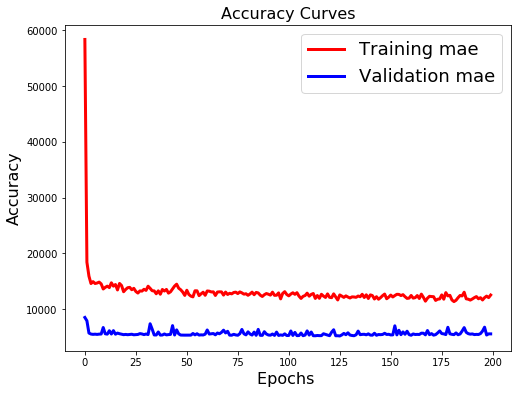

In [15]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [16]:
# Vorhersage generieren
predictions_100 = model.predict(Xtest_100)

predictions_train_100=model.predict(Xtrain_100)

In [17]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_100, predictions_100)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_100, predictions_train_100)
print('Train MSE: %.3f' % mse_train)

Test MSE: 49367280.997
Train MSE: 162381240.374


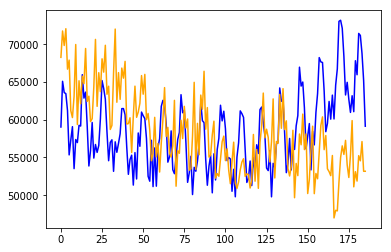

In [18]:
# Verlauf der beobachteten und vorhergesagten Werte
plt.plot(ytest_100, color='blue') # blau: original
plt.plot(predictions_100, color='orange') # orange
plt.show()

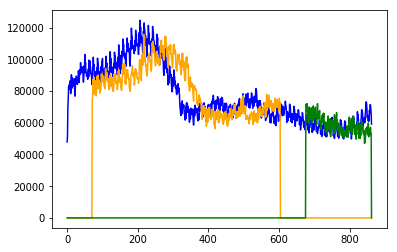

In [19]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_100)+(window_size+look_forward-1)] = predictions_train_100


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(predictions_train_100)+2*(window_size+look_forward)-1:len(ZR_100)-1] = predictions_100
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [27]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [28]:
# Modellanpassen: 46%
history_reg=model.fit(Xtrain_46, ytrain_46, epochs=200, batch_size=25, validation_data=(Xtest_46, ytest_46))

Train on 188 samples, validate on 68 samples
Epoch 1/200
188/188 [==============================] - 0s 665us/step - loss: 53879397.7234 - mean_absolute_error: 5964.6510 - val_loss: 108174852.9412 - val_mean_absolute_error: 8813.3541
Epoch 2/200
188/188 [==============================] - 0s 499us/step - loss: 57728993.2128 - mean_absolute_error: 6026.3809 - val_loss: 92595919.6176 - val_mean_absolute_error: 7964.2074
Epoch 3/200
188/188 [==============================] - 0s 582us/step - loss: 58298695.0213 - mean_absolute_error: 6275.5777 - val_loss: 135990899.2647 - val_mean_absolute_error: 10126.2453
Epoch 4/200
188/188 [==============================] - 0s 582us/step - loss: 58076763.2766 - mean_absolute_error: 6129.8345 - val_loss: 87996181.1618 - val_mean_absolute_error: 7709.3873
Epoch 5/200
188/188 [==============================] - 0s 914us/step - loss: 56896758.5000 - mean_absolute_error: 5866.4935 - val_loss: 132251962.7059 - val_mean_absolute_error: 9992.1870
Epoch 6/200
188/

188/188 [==============================] - 0s 582us/step - loss: 63758365.0638 - mean_absolute_error: 6421.3819 - val_loss: 145887186.5294 - val_mean_absolute_error: 10671.0212
Epoch 45/200
188/188 [==============================] - 0s 582us/step - loss: 53252310.7766 - mean_absolute_error: 5777.0198 - val_loss: 96220034.3235 - val_mean_absolute_error: 8207.8322
Epoch 46/200
188/188 [==============================] - 0s 582us/step - loss: 60878828.5319 - mean_absolute_error: 6161.8178 - val_loss: 132708506.2647 - val_mean_absolute_error: 10068.6104
Epoch 47/200
188/188 [==============================] - 0s 582us/step - loss: 56285622.7872 - mean_absolute_error: 5721.6045 - val_loss: 100771148.5882 - val_mean_absolute_error: 8438.9987
Epoch 48/200
188/188 [==============================] - 0s 582us/step - loss: 60039039.4787 - mean_absolute_error: 6269.6801 - val_loss: 111940212.1765 - val_mean_absolute_error: 9012.8901
Epoch 49/200
188/188 [==============================] - 0s 499us/st

188/188 [==============================] - 0s 499us/step - loss: 44371926.4043 - mean_absolute_error: 5215.9236 - val_loss: 134532816.0882 - val_mean_absolute_error: 10132.5531
Epoch 88/200
188/188 [==============================] - 0s 582us/step - loss: 70054183.9362 - mean_absolute_error: 6526.7641 - val_loss: 101504701.6471 - val_mean_absolute_error: 8502.6270
Epoch 89/200
188/188 [==============================] - 0s 582us/step - loss: 48137906.0957 - mean_absolute_error: 5554.4991 - val_loss: 119207190.0000 - val_mean_absolute_error: 9412.5953
Epoch 90/200
188/188 [==============================] - 0s 748us/step - loss: 46279122.3936 - mean_absolute_error: 5548.5985 - val_loss: 106485570.1765 - val_mean_absolute_error: 8709.4868
Epoch 91/200
188/188 [==============================] - 0s 748us/step - loss: 48784256.0426 - mean_absolute_error: 5660.8057 - val_loss: 116244320.8529 - val_mean_absolute_error: 9199.7329
Epoch 92/200
188/188 [==============================] - 0s 582us/st

188/188 [==============================] - 0s 582us/step - loss: 66942733.4468 - mean_absolute_error: 6383.1872 - val_loss: 128461782.9412 - val_mean_absolute_error: 9854.5986
Epoch 131/200
188/188 [==============================] - 0s 582us/step - loss: 68879551.0426 - mean_absolute_error: 6583.8234 - val_loss: 113190567.1029 - val_mean_absolute_error: 9068.5207
Epoch 132/200
188/188 [==============================] - 0s 665us/step - loss: 51555671.6170 - mean_absolute_error: 5860.6603 - val_loss: 104360426.5294 - val_mean_absolute_error: 8617.7039
Epoch 133/200
188/188 [==============================] - 0s 499us/step - loss: 54133028.5106 - mean_absolute_error: 5899.6983 - val_loss: 111731766.0000 - val_mean_absolute_error: 9014.7026
Epoch 134/200
188/188 [==============================] - 0s 582us/step - loss: 49312530.3191 - mean_absolute_error: 5540.5247 - val_loss: 116879318.9412 - val_mean_absolute_error: 9293.9686
Epoch 135/200
188/188 [==============================] - 0s 582u

188/188 [==============================] - 0s 582us/step - loss: 53080763.5213 - mean_absolute_error: 5792.5559 - val_loss: 84703023.8162 - val_mean_absolute_error: 7474.6125
Epoch 174/200
188/188 [==============================] - 0s 582us/step - loss: 51321276.0000 - mean_absolute_error: 5731.9709 - val_loss: 119430276.1765 - val_mean_absolute_error: 9380.7477
Epoch 175/200
188/188 [==============================] - 0s 499us/step - loss: 52403066.5532 - mean_absolute_error: 6058.1406 - val_loss: 122887102.2059 - val_mean_absolute_error: 9552.3313
Epoch 176/200
188/188 [==============================] - 0s 582us/step - loss: 53728185.6170 - mean_absolute_error: 5912.9592 - val_loss: 129188275.6471 - val_mean_absolute_error: 9864.5966
Epoch 177/200
188/188 [==============================] - 0s 582us/step - loss: 64008009.5745 - mean_absolute_error: 6360.7104 - val_loss: 89077249.7353 - val_mean_absolute_error: 7770.2447
Epoch 178/200
188/188 [==============================] - 0s 582us/

Text(0.5,1,'Loss Curves')

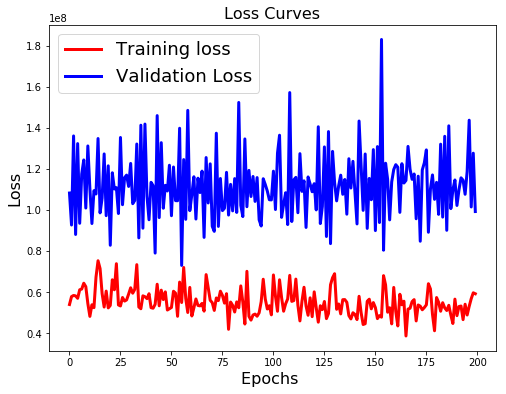

In [29]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

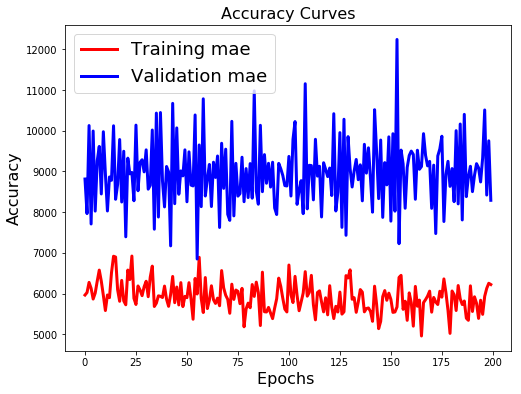

In [30]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [31]:
# Vorhersage generieren
predictions_46 = model.predict(Xtest_46)

predictions_train_46=model.predict(Xtrain_46)

In [32]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_46, predictions_46)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_46, predictions_train_46)
print('Train MSE: %.3f' % mse_train)

Test MSE: 99168047.975
Train MSE: 15864755.126


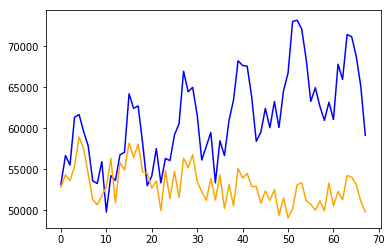

In [33]:
# Verlauf der beobachteten und vorhergesagten Werte
plt.plot(ytest_46, color='blue') 
plt.plot(predictions_46, color='orange')
plt.show()

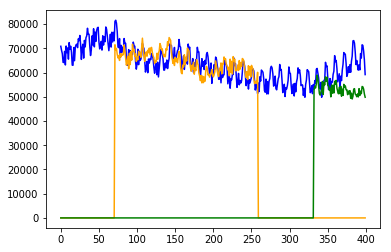

In [34]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_46)+(window_size+look_forward-1)] = predictions_train_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(predictions_train_46)+2*(window_size+look_forward):len(ZR)-1] = predictions_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()